In [19]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [20]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [21]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [22]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_sample
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recursive tree building procedure.
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        # Your code goes here
        n,m = X.shape
        #check the boundary conditions of a decision tree
        if self.depth == self.max_depth or n <= self.min_sample or len(np.unique(y))<=1:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        self.find_best_split_feature(X,y)  #This routine aims to find the optimal split_id and split_value
        x_left = X[X[:, self.split_id] <= self.split_value]
        y_left = y[X[:, self.split_id] <= self.split_value]
        x_right = X[X[:, self.split_id] > self.split_value]
        y_right = y[X[:, self.split_id] > self.split_value]

        split_loss = (self.split_loss_function(y_left)*len(y_left) +
                     self.split_loss_function(y_right)*len(y_right))/n
        if split_loss < self.split_loss_function(y):
            # we only split the node if the splitting can lead to smaller loss
            self.is_leaf = False
            self.left = Decision_Tree(self.split_loss_function,self.leaf_value_estimator,self.depth+1,self.min_sample,self.max_depth)
            self.right = Decision_Tree(self.split_loss_function,self.leaf_value_estimator,self.depth+1,self.min_sample,self.max_depth)
            self.left.fit(x_left, y_left)
            self.right.fit(x_right, y_right)
        else:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        return self
    def find_best_split_point(self,X, y, ftr_id):
        #For feature number ftr_id, returns the optimal splitting point for data X_node, y_node, and corresponding loss
        #param X: a numpy array of training data, shape = (num_samples,num_features)
        #param y: a numpy array of labels, shape = (num_samples, 1)

        n = X.shape[0]
        sort_x = np.sort(X[:, ftr_id]) #sort X according to split feature, we need to try n-1 different split points.
        split_points = []#record n-1 different split points
        loss = [] #records loss corresponding to n-1 different split points

        for i in range(n-1):
            split = 0.5*(sort_x[i]+sort_x[i+1])
            split_points.append(split)
            left = y[X[:, ftr_id]<=split]
            right = y[X[:, ftr_id]>split]
            l = (self.split_loss_function(left)*len(left)+self.split_loss_function(right)*len(right))/n
            loss.append(l)
        #now we have n-1 split points and its corresponding split loss
        #we need to find the optimal split point and its loss. Note:This is the SOTA when we choose feature indexed by ftr_id
        optimal_loss = min(loss)
        optimal_point = split_points[np.argmin(loss)]
        return optimal_point, optimal_loss

    def find_best_split_feature(self,X,y):
        #In the method find_best_split_point we are given the ftr_id and we find the SOTA when we use ftr_id to split
        #now we need to try all feature id (i.e. try all features), and compare all SOTAs, and find the best one
        num_feature = X.shape[1]
        maps = []
        for f_id in range(num_feature):
            split_point, split_loss = self.find_best_split_point(X,y,f_id)
            maps.append([f_id,split_point,split_loss])

        min_split = min(maps,key=lambda x:x[2])
        self.split_id = min_split[0]
        self.split_value = min_split[1]
    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [23]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    N = len(label_array)
    if N == 0:
        return 0
    P = np.sum(label_array)/N
    if P == 0 or (1-P) == 0:
        return 0
    entropy = -P * np.log2(P) - (1-P) * np.log2(1-P)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    N = len(label_array)
    P = np.sum(label_array)/N
    gini = 1- (P**2 + (1-P)**2)
    return gini

In [24]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [25]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

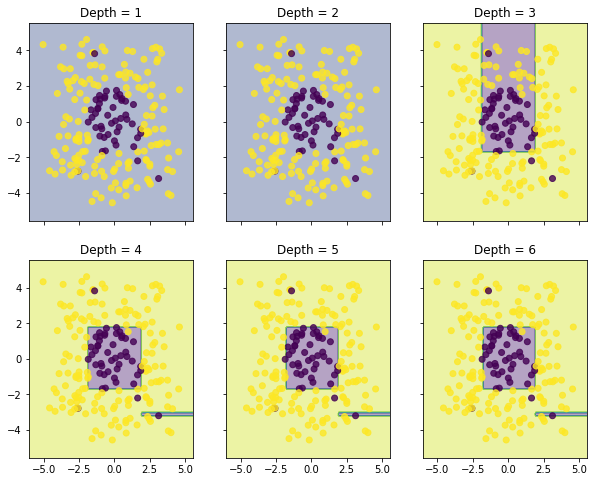

In [26]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [27]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [28]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

/bin/bash: dot: command not found


In [29]:
Image(filename='tree_classifier.png')

FileNotFoundError: [Errno 2] No such file or directory: 'tree_classifier.png'

# Decision Tree Regressor

In [30]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    n = len(y)
    median = np.median(y)
    mae = sum(abs(y-median))/n

    return mae

In [31]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

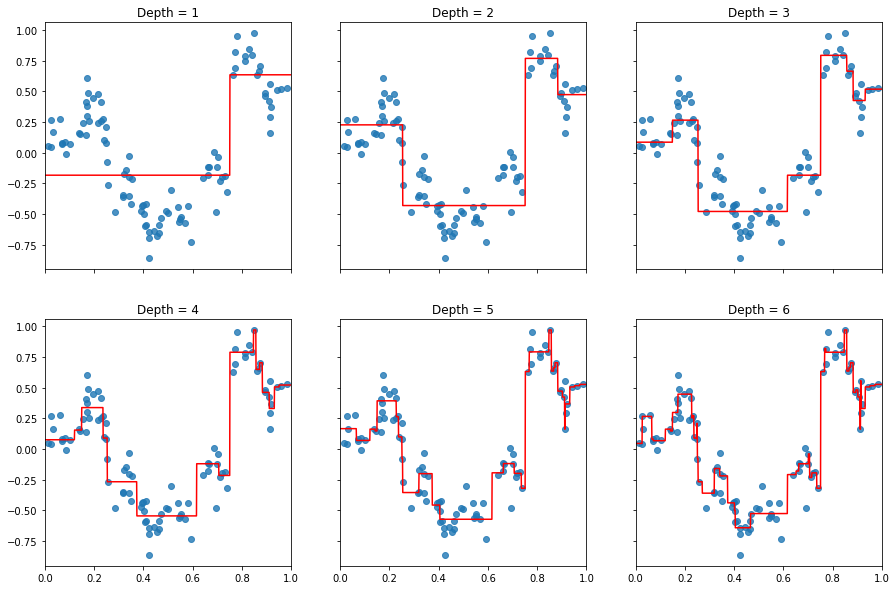

In [49]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [79]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

def pseudo_residual_logistic(train_target, train_predict):
    n = train_target.shape[0]
    res = np.zeros((n,1))
    for i in range(n):
        res[i] = train_target[i]/(1+np.exp(train_target[i]*train_predict[i]))
    return res

In [80]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.estimators = []
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        n = train_data.shape[0]
        train_predict = np.zeros((n,1))
        for i in range(self.n_estimator):
            regressor = DecisionTreeRegressor(max_depth=self.max_depth,min_samples_split=self.min_sample,criterion="squared_error")
            residual = self.pseudo_residual_func(train_target, train_predict)
            regressor.fit(train_data, residual)
            train_predict = train_predict + self.learning_rate * regressor.predict(train_data, check_input=True).reshape((n,1))
            self.estimators.append(regressor)
    def predict(self, test_data):
        '''
        Predict value
        '''
        # Your code goes here
        n = test_data.shape[0]
        test_predict = np.zeros((n,1))
        for regressor in self.estimators:
            test_predict = test_predict + self.learning_rate * regressor.predict(test_data).reshape((n,1))
        return test_predict

# 2-D GBM visualization - SVM data

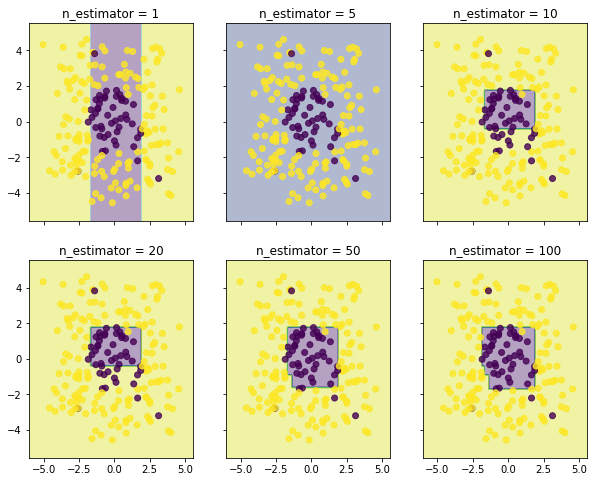

In [82]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization - KRR data

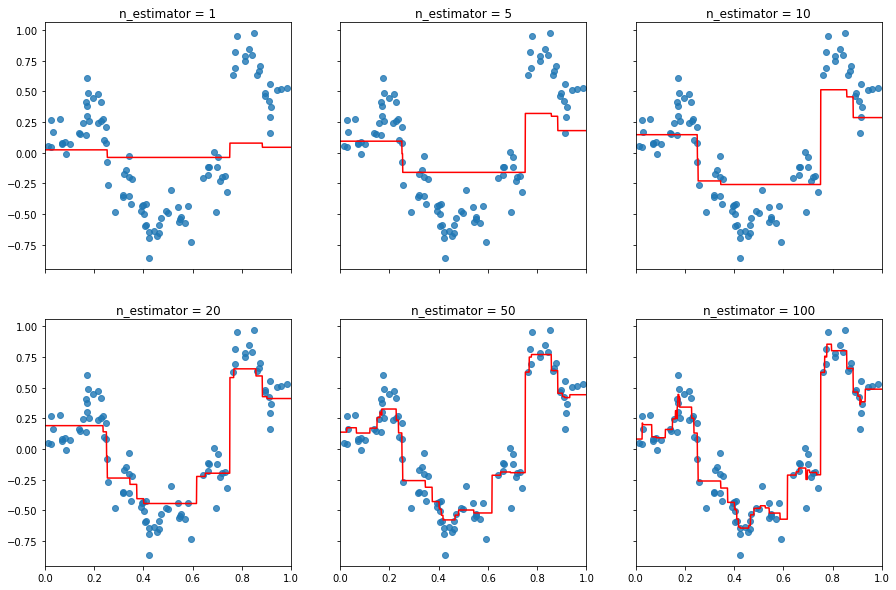

In [83]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)